In [239]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
import src.util as util
import yaml
import copy
from tqdm import tqdm
import os
from datetime import datetime
import openpyxl
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [240]:
config_data=util.config_load()

In [256]:
data_if_rank=util.pickle_load(config_data['raw_dataset_path_if_rank'])
data_lof_rank=util.pickle_load(config_data['raw_dataset_path_lof_rank'])
data_rrcf_rank=util.pickle_load(config_data['raw_dataset_path_rrcf_rank'])
data_if_prv_amt_rank=util.pickle_load(config_data['raw_dataset_path_if_amt_rank'])
data_combined=util.pickle_load(config_data["raw_dataset_path_data_combined"])

In [257]:
data_combined[data_combined.Provider=='PRV51459']['PRV_TotalInscClaimAmtReimbursed']

21    2321890
Name: PRV_TotalInscClaimAmtReimbursed, dtype: int64

In [243]:
len(data_if_rank)

195

In [258]:
rankings_rrcf=data_if_rank.set_index('Rank')['Provider']
rankings_lof=data_lof_rank.set_index('Rank')['Provider']
rankings_if=data_rrcf_rank.set_index('Rank')['Provider']
rankings_if_prv_amt=data_if_prv_amt_rank['Provider']

In [245]:
rankings_lof

Rank
1      PRV52473
2      PRV53061
3      PRV51248
4      PRV57455
5      PRV57690
         ...   
537    PRV55205
538    PRV55839
539    PRV51735
540    PRV56322
541    PRV52072
Name: Provider, Length: 541, dtype: object

In [259]:
def borda_rankings(rankings):
    # Dictionary to store points for each provider
    points = {}
    
    # List to store the sum of points for the first 3 rankings and last ranking
    first_three_points = {}
    last_points = {}
    
    # Iterate through each ranking (model)
    for i, ranking in enumerate(rankings):
        num_candidates = len(ranking)
        
        # Iterate through each provider in the ranking
        for index, candidate in ranking.items():
            if candidate not in points:
                points[candidate] = 0
            
            # Points are calculated based on the rank in the current ranking
            points[candidate] += (num_candidates - index) / (num_candidates - 1)
            
            # For the first three rankings, add points to the sum
            if i < 3:
                if candidate not in first_three_points:
                    first_three_points[candidate] = 0
                first_three_points[candidate] += (num_candidates - index) / (num_candidates - 1)
            
            # For the last ranking, add points to the sum
            if i == len(rankings) - 1:
                if candidate not in last_points:
                    last_points[candidate] = 0
                last_points[candidate] += (num_candidates - index) / (num_candidates - 1)
    
    # Prepare the data for the DataFrame
    df_results = pd.DataFrame(list(points.items()), columns=['Provider', 'Borda_points'])
    
    # Add the sum of points from the first three rankings and the last ranking
    df_results['Sum_first_three_points'] = df_results['Provider'].apply(lambda x: first_three_points.get(x, 0))
    df_results['Sum_last_points'] = round(df_results['Provider'].apply(lambda x: last_points.get(x, 0)),2)
    df_results['avg_ICD'] = round(df_results['Sum_first_three_points']/3,2)
    df_results['Total_avg'] = round((df_results['Sum_first_three_points']/3)+( df_results['Sum_last_points']),2)
    
    # Sort the dataframe based on Borda points in descending order
    df_results_sorted = df_results.sort_values('Total_avg', ascending=False)
    
    return df_results_sorted, points

In [260]:
rankings_if_prv_amt

Rank
1      PRV52019
2      PRV56560
3      PRV56416
4      PRV55215
5      PRV55462
         ...   
467    PRV55850
468    PRV52299
469    PRV54925
470    PRV51196
471    PRV54653
Name: Provider, Length: 471, dtype: object

In [261]:
ranking=[
    rankings_rrcf, 
    rankings_lof,   
    rankings_if,
    rankings_if_prv_amt

]

In [262]:
df_borda_rankings,points=borda_rankings(ranking)


In [263]:
df_borda_rankings

,Provider,Borda_points,Sum_first_three_points,Sum_last_points,avg_ICD,Total_avg
0,PRV51459,3.852049,2.864815,0.99,0.95,1.94
1,PRV53797,3.412103,2.450401,0.96,0.82,1.78
2,PRV51574,3.347965,2.384135,0.96,0.79,1.75
7,PRV52019,2.912066,1.912066,1.00,0.64,1.64
10,PRV55462,2.921424,1.929935,0.99,0.64,1.63
...,...,...,...,...,...,...
726,PRV57518,0.009259,0.009259,0.00,0.00,0.00
729,PRV51735,0.003704,0.003704,0.00,0.00,0.00
730,PRV56322,0.001852,0.001852,0.00,0.00,0.00
194,PRV52593,0.000000,0.000000,0.00,0.00,0.00


In [264]:
df_borda_rankings_top=df_borda_rankings[df_borda_rankings.Total_avg>1]

In [265]:
len(df_borda_rankings_top)

95

Evaluation with true label

In [266]:
datacomp=pd.read_csv('Train-1542865627584.csv')

In [268]:
data_compare=datacomp.merge(df_borda_rankings_top,on='Provider',how='left')

In [269]:
df_borda_rankings_top

,Provider,Borda_points,Sum_first_three_points,Sum_last_points,avg_ICD,Total_avg
0,PRV51459,3.852049,2.864815,0.99,0.95,1.94
1,PRV53797,3.412103,2.450401,0.96,0.82,1.78
2,PRV51574,3.347965,2.384135,0.96,0.79,1.75
7,PRV52019,2.912066,1.912066,1.00,0.64,1.64
10,PRV55462,2.921424,1.929935,0.99,0.64,1.63
...,...,...,...,...,...,...
112,PRV53808,1.333319,0.422680,0.91,0.14,1.05
71,PRV51005,2.026298,1.485872,0.54,0.50,1.04
74,PRV54688,1.676713,0.985223,0.69,0.33,1.02
171,PRV51146,1.145822,0.192631,0.95,0.06,1.01


In [270]:
data_correct=data_compare[(data_compare.PotentialFraud=='Yes') & (data_compare.Total_avg.notna())]

In [271]:
len(data_correct)

88

In [225]:
data_compare['pred']=data_compare['Borda_points'].apply(lambda x: 1 if x>0 else 0  )
data_compare['Actual']=data_compare['PotentialFraud'].apply(lambda x: 1 if x=='Yes' else 0  )

In [226]:
data_compare

,Provider,PotentialFraud,Borda_points,Sum_first_three_points,Sum_last_points,avg_ICD,Total_avg,pred,Actual
0,PRV51001,No,NaN,NaN,NaN,NaN,NaN,0,0
1,PRV51003,Yes,NaN,NaN,NaN,NaN,NaN,0,1
2,PRV51004,No,NaN,NaN,NaN,NaN,NaN,0,0
3,PRV51005,Yes,2.016341,1.460064,0.56,0.49,1.05,1,1
4,PRV51007,No,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...
5405,PRV57759,No,NaN,NaN,NaN,NaN,NaN,0,0
5406,PRV57760,No,NaN,NaN,NaN,NaN,NaN,0,0
5407,PRV57761,No,NaN,NaN,NaN,NaN,NaN,0,0
5408,PRV57762,No,NaN,NaN,NaN,NaN,NaN,0,0


In [78]:
from sklearn import metrics

In [173]:
confusion_matrix = metrics.confusion_matrix(data_compare['Actual'], data_compare['pred'])

In [174]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

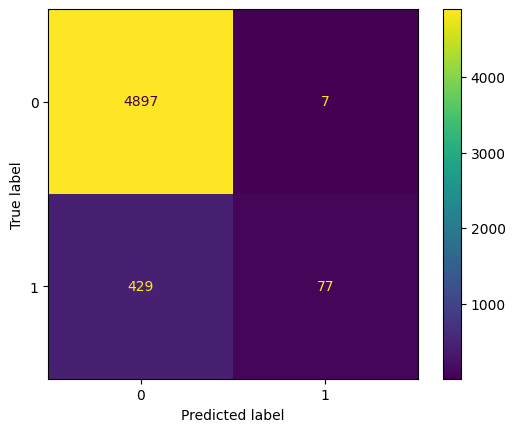

In [175]:
cm_display.plot()
plt.show()

In [176]:
Accuracy = metrics.accuracy_score(data_compare['Actual'], data_compare['pred'])

In [177]:
Accuracy

0.9194085027726433

In [178]:
F1_score = metrics.f1_score(data_compare['Actual'], data_compare['pred'])

In [179]:
F1_score

0.26101694915254237

In [180]:
Precision = metrics.precision_score(data_compare['Actual'], data_compare['pred'])

In [181]:
Precision

0.9166666666666666

In [182]:
Sensitivity_recall = metrics.recall_score(data_compare['Actual'], data_compare['pred'])

In [183]:
Sensitivity_recall

0.15217391304347827

In [227]:
sorted=data_compare.sort_values(by='Borda_points',ascending=False)

In [228]:
data_compare[(data_compare.PotentialFraud=='Yes') & (data_compare.Borda_points.notna())]

,Provider,PotentialFraud,Borda_points,Sum_first_three_points,Sum_last_points,avg_ICD,Total_avg,pred,Actual
3,PRV51005,Yes,2.016341,1.460064,0.56,0.49,1.05,1,1
113,PRV51145,Yes,1.460221,0.607407,0.85,0.20,1.05,1,1
114,PRV51146,Yes,1.162235,0.207689,0.95,0.07,1.02,1,1
190,PRV51244,Yes,2.583375,1.611514,0.97,0.54,1.51,1,1
273,PRV51347,Yes,2.715739,1.854267,0.86,0.62,1.48,1,1
...,...,...,...,...,...,...,...,...,...
4861,PRV57103,Yes,2.643636,1.754026,0.89,0.58,1.47,1,1
4922,PRV57172,Yes,2.757877,1.801167,0.96,0.60,1.56,1,1
4923,PRV57173,Yes,2.149135,1.246538,0.90,0.42,1.32,1,1
4939,PRV57191,Yes,1.881353,0.907327,0.97,0.30,1.27,1,1


In [229]:
data_comb=data_combined[['PRV_TotalInscClaimAmtReimbursed','Provider']]

In [230]:
data_full1=data_compare.merge(data_comb,on='Provider',how='inner')

In [231]:
data_full1[data_full1.Provider=='PRV51459']

,Provider,PotentialFraud,Borda_points,Sum_first_three_points,Sum_last_points,avg_ICD,Total_avg,pred,Actual,PRV_TotalInscClaimAmtReimbursed
363,PRV51459,Yes,3.648124,2.661111,0.99,0.89,1.88,1,1,508210


In [232]:
data_mat=util.pickle_load(config_data["raw_dataset_path_data_matrix"])

In [233]:
data_mat=data_mat[['Provider','Anomaly_ind','Anomaly_score']]

In [234]:
data_full2=data_full1.merge(data_mat,on='Provider',how='inner')

In [235]:
data_full2

,Provider,PotentialFraud,Borda_points,Sum_first_three_points,Sum_last_points,avg_ICD,Total_avg,pred,Actual,PRV_TotalInscClaimAmtReimbursed,Anomaly_ind,Anomaly_score
0,PRV51001,No,NaN,NaN,NaN,NaN,NaN,0,0,797790,1,0.136999
1,PRV51003,Yes,NaN,NaN,NaN,NaN,NaN,0,1,98250,1,0.004424
2,PRV51004,No,NaN,NaN,NaN,NaN,NaN,0,0,1720120,1,0.067138
3,PRV51005,Yes,2.016341,1.460064,0.56,0.49,1.05,1,1,4960,-1,-0.211836
4,PRV51007,No,NaN,NaN,NaN,NaN,NaN,0,0,30130,1,0.106610
...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,No,NaN,NaN,NaN,NaN,NaN,0,0,11400,1,0.140546
5406,PRV57760,No,NaN,NaN,NaN,NaN,NaN,0,0,2424430,1,0.141114
5407,PRV57761,No,NaN,NaN,NaN,NaN,NaN,0,0,505000,1,0.100166
5408,PRV57762,No,NaN,NaN,NaN,NaN,NaN,0,0,2284560,1,0.121545


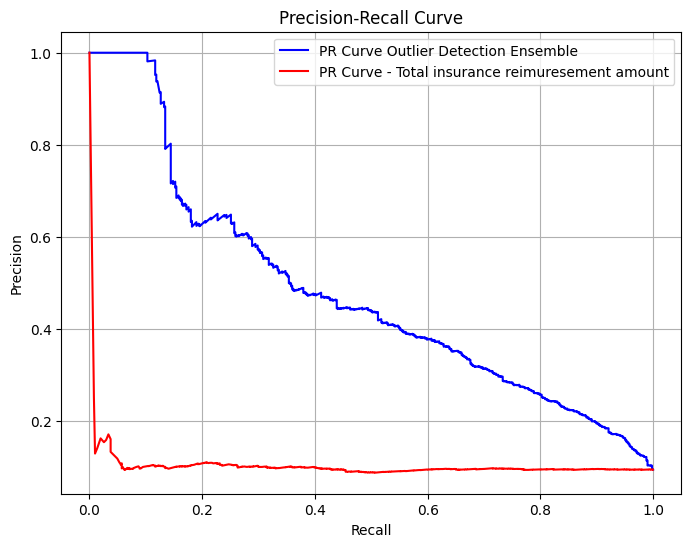

In [236]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
precision, recall, _ = precision_recall_curve( data_compare['Actual'],-data_full2['Anomaly_score'])
precision_baseline2, recall_baseline2, _ = precision_recall_curve(data_compare['Actual'], data_full2['PRV_TotalInscClaimAmtReimbursed']) 

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label='PR Curve Outlier Detection Ensemble')
plt.plot(recall_baseline2, precision_baseline2, color='r', label='PR Curve - Total insurance reimuresement amount' )
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

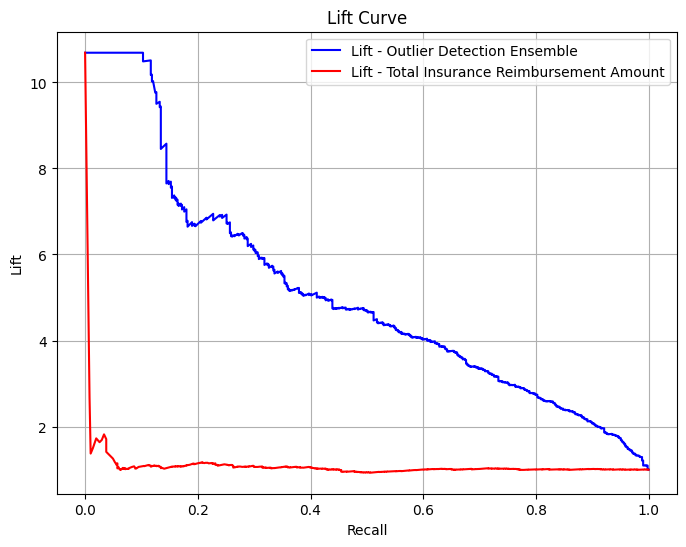

In [238]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Compute precision, recall, and thresholds for the two models
precision, recall, thresholds = precision_recall_curve(data_compare['Actual'], -data_full2['Anomaly_score'])
precision_baseline2, recall_baseline2, thresholds_baseline2 = precision_recall_curve(data_compare['Actual'], data_full2['PRV_TotalInscClaimAmtReimbursed'])

# Calculate baseline precision (the proportion of positive instances in the data)
baseline_precision = np.sum(data_compare['Actual'] == 1) / len(data_compare['Actual'])
baseline_precision_baseline2 = np.sum(data_compare['Actual'] == 1) / len(data_compare['Actual'])

# Compute Lift for both models
lift = precision / baseline_precision
lift_baseline2 = precision_baseline2 / baseline_precision_baseline2

# Plot Lift curve
plt.figure(figsize=(8, 6))
plt.plot(recall, lift, color='b', label='Lift - Outlier Detection Ensemble')
plt.plot(recall_baseline2, lift_baseline2, color='r', label='Lift - Total Insurance Reimbursement Amount')
plt.xlabel('Recall')
plt.ylabel('Lift')
plt.title('Lift Curve')
plt.grid(True)
plt.legend()
plt.show()